# DROID TFDS → HDF5 변환기 (Notebook 버전)
요청하신 스펙에 맞춰 **action(10)=pos(3)+rot6d(6)+gripper(1)**, 멀티뷰 이미지, qpos/qvel, joint_positions를 저장합니다.

**사용 순서**
1) 아래 '환경 준비' 셀에서 필요 패키지 설치(이미 설치되어 있으면 건너뛰기)
2) '설정(Parameters)' 값을 수정
3) '실행' 셀을 순서대로 실행


## 1. 환경 준비
필요 시 주석을 해제하고 설치하세요.

In [ ]:

# !pip install tensorflow-datasets h5py pillow tqdm
# !pip install torch  # rot6d 변환에 사용


## 2. 유틸 함수 (회전 변환 등)

In [2]:

import torch

def _axis_angle_rotation(axis, angle: torch.Tensor) -> torch.Tensor:
    """주어진 축(axis)와 각(angle)로 회전행렬(3x3) 생성."""
    cos = torch.cos(angle)
    sin = torch.sin(angle)
    one = torch.ones_like(angle)
    if axis == "X":
        R = (one, 0*angle, 0*angle, 0*angle, cos, -sin, 0*angle, sin, cos)
    elif axis == "Y":
        R = (cos, 0*angle, sin, 0*angle, one, 0*angle, -sin, 0*angle, cos)
    elif axis == "Z":
        R = (cos, -sin, 0*angle, sin, cos, 0*angle, 0*angle, 0*angle, one)
    else:
        raise ValueError("Axis must be X, Y, or Z")
    return torch.stack(R, -1).reshape(angle.shape + (3, 3))

def euler_angles_to_matrix(euler_angles: torch.Tensor, convention: str) -> torch.Tensor:
    """오일러 각(euler_angles: (...,3))을 회전행렬(...,3,3)로 변환."""
    matrices = [_axis_angle_rotation(c, e) for c, e in zip(convention, torch.unbind(euler_angles, -1))]
    return matrices[0] @ matrices[1] @ matrices[2]

def matrix_to_rotation_6d(matrix: torch.Tensor) -> torch.Tensor:
    """회전행렬(...,3,3) → 6D 표현(...,6): 첫 2개 열을 펼쳐 사용."""
    batch_dim = matrix.size()[:-2]
    return matrix[..., :2, :].clone().reshape(batch_dim + (6,))

def euler_angles_to_rot_6d(euler_angles: torch.Tensor, convention: str = "XYZ") -> torch.Tensor:
    """오일러 각 → 6D 회전표현."""
    return matrix_to_rotation_6d(euler_angles_to_matrix(euler_angles, convention))


In [3]:
# === 언어 탐색 / 프레임 추출 / GIF 생성 유틸 ===
import os, io, numpy as np, tensorflow_datasets as tfds
from PIL import Image as PILImage
from IPython.display import display, Image as IPyImage

def find_language_from_episode(episode) -> str | None:
    """에피소드의 steps를 훑어 lang1>lang2>lang3 순으로 4자 이상 문장을 찾으면 반환, 없으면 None."""
    steps_np = list(tfds.as_numpy(episode['steps']))
    def _dec(b):
        if isinstance(b, bytes):
            try: return b.decode('utf-8').strip()
            except: return ''
        elif isinstance(b, str):
            return b.strip()
        return ''
    for s in steps_np:
        l1 = _dec(s.get('language_instruction', b''))
        l2 = _dec(s.get('language_instruction_2', b''))
        l3 = _dec(s.get('language_instruction_3', b''))
        cand = l1 if len(l1) >= 4 else (l2 if len(l2) >= 4 else l3)
        if len(cand) >= 4:
            return cand
    return None

def extract_left_frames(episode, max_frames: int = 60, step_stride: int = 1):
    """좌측 카메라 프레임을 최대 max_frames장 추출(간격=step_stride)."""
    frames = []
    n = 0
    for i, s in enumerate(tfds.as_numpy(episode['steps'])):
        if i % step_stride != 0:
            continue
        img = s['observation']['exterior_image_1_left']
        if img.ndim == 3 and img.shape[0] in (1,3) and img.shape[0] < img.shape[1]:
            img = np.transpose(img, (1,2,0))  # CHW -> HWC
        if img.dtype != np.uint8:
            # 0~1이면 255 스케일, 아니면 클리핑
            m, M = float(img.min()), float(img.max())
            if 0.0 <= m <= 1.0 and 0.0 <= M <= 1.0:
                img = (img * 255.0).round().astype(np.uint8)
            else:
                img = np.clip(img, 0, 255).astype(np.uint8)
        frames.append(img)
        n += 1
        if n >= max_frames:
            break
    return frames

def make_and_show_gif(frames, out_dir: str, fname: str = "preview.gif", fps: int = 12, scale: float = 1.0):
    """프레임 리스트로 GIF 생성 후 표시. scale<1.0이면 축소 저장."""
    os.makedirs(out_dir, exist_ok=True)
    path = os.path.join(out_dir, fname)

    pil_frames = []
    for f in frames:
        im = PILImage.fromarray(f)
        if scale != 1.0:
            w, h = im.size
            im = im.resize((int(w*scale), int(h*scale)))
        pil_frames.append(im)

    # 최소 2프레임 필요
    if len(pil_frames) == 1:
        pil_frames = [pil_frames[0], pil_frames[0]]

    pil_frames[0].save(
        path, save_all=True, append_images=pil_frames[1:],
        duration=int(1000/max(1, fps)), loop=0, optimize=False
    )
    # 노트북에서 바로 표시
    display(IPyImage(filename=path))
    return path


## 3. 배열/이미지 유틸

In [4]:

import numpy as np
from PIL import Image as PILImage

def _ensure_uint8(img: np.ndarray) -> np.ndarray:
    """이미지 배열을 uint8(HWC)로 정규화."""
    if img.ndim == 3 and img.shape[0] in (1, 3) and img.shape[0] < img.shape[1]:
        img = np.transpose(img, (1, 2, 0))
    if img.dtype != np.uint8:
        m, M = float(img.min()), float(img.max())
        if 0.0 <= m and M <= 1.0:
            img = (img * 255.0).round().astype(np.uint8)
        else:
            img = np.clip(img, 0, 255).astype(np.uint8)
    return img

def _resize_list(img_list, target_w: int, target_h: int):
    """PIL을 사용해 이미지 리스트를 (target_w, target_h)로 리사이즈."""
    return [np.array(PILImage.fromarray(_ensure_uint8(x)).resize((target_w, target_h))) for x in img_list]

def _pad_or_trim(arr: np.ndarray, T: int, pad_value=0) -> np.ndarray:
    """시간축 길이를 T로 맞춤. L<T이면 패딩, L>T이면 앞 T 프레임만 사용."""
    L = arr.shape[0]
    if L == T:
        return arr
    if L > T:
        return arr[:T]
    pad_shape = (T - L,) + arr.shape[1:]
    pad_block = np.full(pad_shape, pad_value, dtype=arr.dtype)
    return np.concatenate([arr, pad_block], axis=0)


## 4. H5 저장기

In [5]:

import h5py

def write_episode_h5(h5_path: str,
                     obs: dict,
                     actions_10: np.ndarray,
                     language: str,
                     H: int,
                     W: int,
                     T_fixed: int):
    """단일 에피소드를 H5로 기록."""
    qpos  = _pad_or_trim(obs['qpos'],  T_fixed, 0)
    qvel  = _pad_or_trim(obs['qvel'],  T_fixed, 0)
    jpos  = _pad_or_trim(obs['joint_positions'], T_fixed, 0)
    left  = _pad_or_trim(obs['images']['left'],  T_fixed, 0)
    right = _pad_or_trim(obs['images']['right'], T_fixed, 0)
    wrist = _pad_or_trim(obs['images']['wrist'], T_fixed, 0)
    act10 = _pad_or_trim(actions_10, T_fixed, 0)

    os.makedirs(os.path.dirname(h5_path), exist_ok=True)
    with h5py.File(h5_path, 'w', rdcc_nbytes=1024**2*2) as root:
        root.attrs['sim'] = True
        root.create_dataset('action', data=act10.astype(np.float32), compression='gzip')
        root.create_dataset('language_raw', data=[np.string_(language)])

        obs_grp = root.create_group('observations')
        img_grp = obs_grp.create_group('images')

        img_grp.create_dataset('left',  data=left.astype(np.uint8),  compression='gzip', chunks=(1, H, W, 3))
        img_grp.create_dataset('right', data=right.astype(np.uint8), compression='gzip', chunks=(1, H, W, 3))
        img_grp.create_dataset('wrist', data=wrist.astype(np.uint8), compression='gzip', chunks=(1, H, W, 3))

        obs_grp.create_dataset('joint_positions', data=jpos.astype(np.float32), compression='gzip')
        obs_grp.create_dataset('qpos',            data=qpos.astype(np.float32), compression='gzip')
        obs_grp.create_dataset('qvel',            data=qvel.astype(np.float32), compression='gzip')


## 5. TFDS → H5 변환 (단일 에피소드 처리)

In [6]:

import tensorflow_datasets as tfds

def convert_episode(episode: dict,
                    cfg: dict,
                    T_fixed: int,
                    rot_in_degrees: bool) -> tuple:
    """단일 TFDS 에피소드에서 H5에 저장할 numpy 패킷 생성."""
    steps_np = list(tfds.as_numpy(episode['steps']))
    if len(steps_np) == 0:
        raise ValueError("Empty episode")

    # 언어 지시문 (lang1 > lang2 > lang3)
    language = None
    for s in steps_np:
        def _dec(b):
            if isinstance(b, bytes):
                try:
                    return b.decode('utf-8').strip()
                except Exception:
                    return ''
            elif isinstance(b, str):
                return b.strip()
            return ''
        l1 = _dec(s.get('language_instruction', b''))
        l2 = _dec(s.get('language_instruction_2', b''))
        l3 = _dec(s.get('language_instruction_3', b''))
        cand = l1 if len(l1) >= 4 else (l2 if len(l2) >= 4 else l3)
        if len(cand) >= 4:
            language = cand
            break
    if language is None:
        language = cfg['default_lang']

    # 이미지/상태/액션 수집
    left_list, right_list, wrist_list = [], [], []
    qpos_list, qvel_list, jpos_list = [], [], []
    pos_list, rot_list, grip_list = [], [], []

    for s in steps_np:
        obs = s.get('observation', {})
        left_list.append(obs['exterior_image_1_left'])
        right_list.append(obs['exterior_image_2_left'])
        wrist_list.append(obs['wrist_image_left'])

        jp = obs.get('joint_position', None)
        if jp is None:
            jp = s.get('action_dict', {}).get('joint_position', np.zeros((7,), np.float32))
        jv = s.get('action_dict', {}).get('joint_velocity', np.zeros((7,), np.float32))

        qpos_list.append(jp); jpos_list.append(jp); qvel_list.append(jv)

        a_cart = s.get('action_dict', {}).get('cartesian_position', None)
        if a_cart is None:
            raise KeyError("action_dict.cartesian_position is required")
        pos_list.append(np.asarray(a_cart[:3], dtype=np.float32))
        rot_list.append(np.asarray(a_cart[3:6], dtype=np.float32))

        grip = s.get('action_dict', {}).get('gripper_position', None)
        if grip is None:
            grip = obs.get('gripper_position', 0.0)
        grip = np.asarray(grip).reshape(-1)
        grip_list.append(np.float32(grip[0]))

    L = min(len(left_list), len(right_list), len(wrist_list), len(qpos_list), len(qvel_list), len(jpos_list), len(pos_list), len(rot_list), len(grip_list))
    left_list, right_list, wrist_list = left_list[:L], right_list[:L], wrist_list[:L]
    qpos_list, qvel_list, jpos_list = qpos_list[:L], qvel_list[:L], jpos_list[:L]
    pos_list, rot_list, grip_list   = pos_list[:L], rot_list[:L], grip_list[:L]

    H0, W0 = left_list[0].shape[:2]
    assert (H0, W0) == tuple(right_list[0].shape[:2]) == tuple(wrist_list[0].shape[:2]), "카메라 해상도 불일치"

    H, W = cfg['cam_height'], cfg['cam_width']
    if (H, W) != (H0, W0):
        if cfg['resize_to_cfg']:
            print(f"Resizing frames to cfg ({H},{W}) from ({H0},{W0})")
            left_list  = _resize_list(left_list,  W, H)
            right_list = _resize_list(right_list, W, H)
            wrist_list = _resize_list(wrist_list, W, H)
        else:
            print(f"Auto-updating cfg cam size to ({H0},{W0})")
            H, W = H0, W0

    left  = np.stack([_ensure_uint8(x) for x in left_list ], axis=0)
    right = np.stack([_ensure_uint8(x) for x in right_list], axis=0)
    wrist = np.stack([_ensure_uint8(x) for x in wrist_list], axis=0)

    qpos = np.asarray(qpos_list, dtype=np.float32).reshape(L, 7)
    qvel = np.asarray(qvel_list, dtype=np.float32).reshape(L, 7)
    jpos = np.asarray(jpos_list, dtype=np.float32).reshape(L, 7)

    pos  = np.asarray(pos_list, dtype=np.float32).reshape(L, 3)
    eul  = np.asarray(rot_list, dtype=np.float32).reshape(L, 3)
    if rot_in_degrees:
        eul = np.deg2rad(eul)
    rot6 = euler_angles_to_rot_6d(torch.from_numpy(eul)).numpy()
    grip = np.asarray(grip_list, dtype=np.float32).reshape(L, 1)

    actions_10 = np.concatenate([pos, rot6, grip], axis=-1)  # (L,10)
    assert actions_10.shape[1] == 10

    obs = {
        'qpos': qpos,
        'qvel': qvel,
        'joint_positions': jpos,
        'images': {'left': left, 'right': right, 'wrist': wrist}
    }
    return obs, actions_10, language, H, W


## 6. 설정 (Parameters)

In [7]:

# ← 여기만 수정해서 사용하세요
DATASET_NAME = "droid_100"        # TFDS dataset name
DATASET_DIR  = "/home/parkjeongsu/TinyVLA/Droid"    # TFDS data_dir
SPLIT        = "train"            # "train"/"validation"/"test"
OUTPUT_DIR   = "/home/parkjeongsu/TinyVLA/Droid/trans_data"  # 출력 디렉토리
TASK_NAME    = "droid_1dot7t_lang"
CAMERA_NAMES = ["left","right","wrist"]
CAM_HEIGHT   = 480
CAM_WIDTH    = 640
QPOS_DIM     = 7
ACTION_DIM   = 10
T_FIXED      = 100
DEFAULT_LANG = "close the lid of the box"
ROT_IN_DEGREES = False            # 오일러 각(deg)라면 True
RESIZE_TO_CFG  = True             # 해상도 불일치 시 리사이즈


## 7. 실행

Output dir: /home/parkjeongsu/TinyVLA/Droid/trans_data/droid_1dot7t_lang_succ_t0001_s-0-0
Loading TFDS: droid_100 (data_dir=/home/parkjeongsu/TinyVLA/Droid, split=train)
[INFO] Trying builder_from_directory: /home/parkjeongsu/TinyVLA/Droid/droid_100/1.0.0
Resizing frames to cfg (480,640) from (180,320)
Saved episode_0.hdf5 | T=100 | action_dim=10 | qpos/qvel_dim=7 | cam=(480,640) | lang='Put the marker in the pot'
Resizing frames to cfg (480,640) from (180,320)
Saved episode_1.hdf5 | T=100 | action_dim=10 | qpos/qvel_dim=7 | cam=(480,640) | lang='Put the candy bar on the left side of the first shelf'
Resizing frames to cfg (480,640) from (180,320)
Saved episode_2.hdf5 | T=100 | action_dim=10 | qpos/qvel_dim=7 | cam=(480,640) | lang='Put one green sachet in the grey bowl.'
Resizing frames to cfg (480,640) from (180,320)
Saved episode_3.hdf5 | T=100 | action_dim=10 | qpos/qvel_dim=7 | cam=(480,640) | lang='Place the pack of doritos inside the sink'
Resizing frames to cfg (480,640) from (

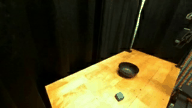

[PREVIEW] /home/parkjeongsu/TinyVLA/Droid/trans_data/_preview_gifs/episode_5.gif
Resizing frames to cfg (480,640) from (180,320)
Saved episode_5.hdf5 | T=100 | action_dim=10 | qpos/qvel_dim=7 | cam=(480,640) | lang='pick the green cube up'
Resizing frames to cfg (480,640) from (180,320)
Saved episode_6.hdf5 | T=100 | action_dim=10 | qpos/qvel_dim=7 | cam=(480,640) | lang='Take the pen out of the bowl and place it on the table'


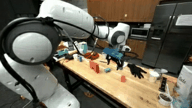

[PREVIEW] /home/parkjeongsu/TinyVLA/Droid/trans_data/_preview_gifs/episode_7.gif


KeyboardInterrupt: Interrupted by user

In [8]:
#바로 위 셀 수정한것
# === 실행 루프 (언어 없음 → GIF 미리보기 & 수동 입력) ===
import os, tensorflow_datasets as tfds

# 프리뷰 GIF 저장 위치
PREVIEW_DIR = os.path.join(OUTPUT_DIR, "_preview_gifs")
SKIP_IF_NO_LANG = False     # False면 프리뷰를 띄우고 수동 입력 기회 제공
DEFAULT_IF_EMPTY = False    # 프롬프트가 비면 default_lang로 진행(False면 스킵)

cfg = {
    'task_name': TASK_NAME,
    'camera_names': CAMERA_NAMES,
    'cam_height': CAM_HEIGHT,
    'cam_width': CAM_WIDTH,
    'qpos_dim': QPOS_DIM,
    'action_dim': ACTION_DIM,
    'default_lang': DEFAULT_LANG,
    'resize_to_cfg': RESIZE_TO_CFG,
}

act_root_dir_name = f"{cfg['task_name']}_succ_t0001_s-0-0"
act_root_dir_path = os.path.join(OUTPUT_DIR, act_root_dir_name)
os.makedirs(act_root_dir_path, exist_ok=True)
print("Output dir:", act_root_dir_path)

print(f"Loading TFDS: {DATASET_NAME} (data_dir={DATASET_DIR}, split={SPLIT})")
ds = smart_load(DATASET_NAME, DATASET_DIR, SPLIT)  # 앞서 만든 smart_load 사용

total_traj_cnt = 0
for episode in ds:
    # 1) 언어 후보 먼저 확인
    language_probe = find_language_from_episode(episode)

    if language_probe is None:
        if SKIP_IF_NO_LANG:
            print(f"[SKIP] episode_{total_traj_cnt}: no language instruction found.")
            total_traj_cnt += 1
            continue

        # 2) 프리뷰 GIF 생성/표시 (좌측 카메라 기준)
        frames = extract_left_frames(episode, max_frames=60, step_stride=2)  # 60프레임/2스텝 간격
        if len(frames) == 0:
            print(f"[SKIP] episode_{total_traj_cnt}: no frames to preview.")
            total_traj_cnt += 1
            continue

        gif_path = make_and_show_gif(frames, PREVIEW_DIR, fname=f"episode_{total_traj_cnt}.gif", fps=12, scale=0.6)
        print(f"[PREVIEW] {gif_path}")

        # 3) 사용자가 언어 지시문 입력(빈 입력 처리 정책 선택)
        try:
            user_lang = input("➡ 이 에피소드의 언어 지시문을 입력하세요 (Enter=건너뛰기/기본문장): ").strip()
        except EOFError:
            user_lang = ""

        if not user_lang:
            if DEFAULT_IF_EMPTY:
                language_probe = cfg['default_lang']
                print(f"[INFO] Empty input → default_lang 사용: '{language_probe}'")
            else:
                print(f"[SKIP] episode_{total_traj_cnt}: empty input.")
                total_traj_cnt += 1
                continue
        else:
            language_probe = user_lang

    # 4) 파일 존재 시 스킵
    h5_path = os.path.join(act_root_dir_path, f"episode_{total_traj_cnt}.hdf5")
    if os.path.exists(h5_path):
        print("Skip existing:", h5_path)
        total_traj_cnt += 1
        continue

    # 5) 변환/저장 (convert_episode의 language를 우리가 확정한 것으로 덮어씀)
    try:
        obs, actions_10, _language_from_episode, H, W = convert_episode(
            episode=episode,
            cfg=cfg,
            T_fixed=T_FIXED,
            rot_in_degrees=ROT_IN_DEGREES,
        )
        language = language_probe if language_probe is not None else (_language_from_episode or cfg['default_lang'])
        write_episode_h5(h5_path, obs, actions_10, language, H, W, T_fixed=T_FIXED)
        print(f"Saved episode_{total_traj_cnt}.hdf5 | T={T_FIXED} | action_dim=10 | qpos/qvel_dim=7 | cam=({H},{W}) | lang='{language}'")
    except Exception as e:
        import traceback; traceback.print_exc()
        print(f"Error at episode_{total_traj_cnt}:", e)
    finally:
        total_traj_cnt += 1

print("All done!")


In [ ]:
import os, tensorflow_datasets as tfds

def is_builder_dir(p: str) -> bool:
    if not p: 
        return False
    return os.path.isfile(os.path.join(p, "dataset_info.json"))

def try_builder(p: str, split: str):
    print(f"[INFO] Trying builder_from_directory: {p}")
    builder = tfds.builder_from_directory(p)
    return builder.as_dataset(split=split)

def smart_load(dataset_name: str, data_dir: str, split: str):
    """
    견고한 로더:
    1) data_dir가 곧바로 빌더 폴더일 경우 → builder_from_directory(data_dir)
    2) data_dir/<name>/1.0.0 이 빌더 폴더일 경우
    3) data_dir/<name> 이 빌더 폴더일 경우
    4) dataset_name 자체가 경로이고 빌더 폴더일 경우
    5) 위가 전부 아니면 tfds.load(name, data_dir)
    """
    # 1) data_dir 자체가 빌더 폴더?
    if is_builder_dir(data_dir):
        return try_builder(data_dir, split)

    # 2) data_dir/<name>/1.0.0
    cand = os.path.join(data_dir or "", dataset_name, "1.0.0")
    if is_builder_dir(cand):
        return try_builder(cand, split)

    # 3) data_dir/<name>
    cand = os.path.join(data_dir or "", dataset_name)
    if is_builder_dir(cand):
        return try_builder(cand, split)

    # 4) dataset_name 자체가 경로(빌더 폴더)일 수 있음
    if is_builder_dir(dataset_name):
        return try_builder(dataset_name, split)

    # 5) 마지막으로 일반 tfds.load 시도
    print("[INFO] Falling back to tfds.load(...)")
    return tfds.load(dataset_name, data_dir=data_dir, split=split)

# ---------- 추가: 언어 지시문 탐색 함수 ----------
def find_language_from_episode(episode) -> str | None:
    """
    에피소드 전 스텝을 훑어 언어 지시문 후보 3개(lang1>lang2>lang3) 중
    4글자 이상인 첫 문장을 찾아 반환. 없으면 None.
    """
    steps_np = list(tfds.as_numpy(episode['steps']))
    def _dec(b):
        if isinstance(b, bytes):
            try: return b.decode('utf-8').strip()
            except: return ''
        elif isinstance(b, str):
            return b.strip()
        return ''
    for s in steps_np:
        l1 = _dec(s.get('language_instruction', b''))
        l2 = _dec(s.get('language_instruction_2', b''))
        l3 = _dec(s.get('language_instruction_3', b''))
        cand = l1 if len(l1) >= 4 else (l2 if len(l2) >= 4 else l3)
        if len(cand) >= 4:
            return cand
    return None
# -----------------------------------------------

# ===================== 여기부터 기존 코드 교체 =====================
import os, tensorflow_datasets as tfds

cfg = {
    'task_name': TASK_NAME,
    'camera_names': CAMERA_NAMES,
    'cam_height': CAM_HEIGHT,
    'cam_width': CAM_WIDTH,
    'qpos_dim': QPOS_DIM,
    'action_dim': ACTION_DIM,
    'default_lang': DEFAULT_LANG,
    'resize_to_cfg': RESIZE_TO_CFG,
}

act_root_dir_name = f"{cfg['task_name']}_succ_t0001_s-0-0"
act_root_dir_path = os.path.join(OUTPUT_DIR, act_root_dir_name)
os.makedirs(act_root_dir_path, exist_ok=True)
print("Output dir:", act_root_dir_path)

print(f"Loading TFDS: {DATASET_NAME} (data_dir={DATASET_DIR}, split={SPLIT})")
ds = smart_load(DATASET_NAME, DATASET_DIR, SPLIT)

total_traj_cnt = 0
for episode in ds:
    # ---------- 추가: 언어 없는 에피소드 PASS ----------
    language_probe = find_language_from_episode(episode)
    if language_probe is None:
        print(f"[SKIP] episode_{total_traj_cnt}: no language instruction found.")
        total_traj_cnt += 1
        continue
    # ---------------------------------------------------

    h5_path = os.path.join(act_root_dir_path, f"episode_{total_traj_cnt}.hdf5")
    if os.path.exists(h5_path):
        print("Skip existing:", h5_path)
        total_traj_cnt += 1
        continue
    try:
        obs, actions_10, language_from_convert, H, W = convert_episode(
            episode=episode,
            cfg=cfg,
            T_fixed=T_FIXED,
            rot_in_degrees=ROT_IN_DEGREES,
        )
        # 우리가 미리 찾은 언어(검증된 값)로 강제 적용
        language = language_probe if language_probe is not None else (language_from_convert or cfg['default_lang'])

        write_episode_h5(h5_path, obs, actions_10, language, H, W, T_fixed=T_FIXED)
        print(f"Saved episode_{total_traj_cnt}.hdf5 | T={T_FIXED} | action_dim=10 | qpos/qvel_dim=7 | cam=({H},{W}) | lang='{language}'")
    except Exception as e:
        import traceback; traceback.print_exc()
        print(f"Error at episode_{total_traj_cnt}:", e)
    finally:
        total_traj_cnt += 1

print("All done!")


Output dir: /home/parkjeongsu/TinyVLA/Droid/trans_data/droid_1dot7t_lang_succ_t0001_s-0-0
Loading TFDS: droid_100 (data_dir=/home/parkjeongsu/TinyVLA/Droid, split=train)
[INFO] Trying builder_from_directory: /home/parkjeongsu/TinyVLA/Droid/droid_100/1.0.0


2025-08-13 11:04:23.394093: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-13 11:04:23.419283: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-13 11:04:23.419312: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-13 11:04:23.420244: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-13 11:04:23.425400: I tensorflow/core/platform/cpu_feature_guar

Resizing frames to cfg (480,640) from (180,320)
Saved episode_0.hdf5 | T=100 | action_dim=10 | qpos/qvel_dim=7 | cam=(480,640) | lang='Put the marker in the pot'
Resizing frames to cfg (480,640) from (180,320)
Saved episode_1.hdf5 | T=100 | action_dim=10 | qpos/qvel_dim=7 | cam=(480,640) | lang='Put the candy bar on the left side of the first shelf'
Resizing frames to cfg (480,640) from (180,320)
Saved episode_2.hdf5 | T=100 | action_dim=10 | qpos/qvel_dim=7 | cam=(480,640) | lang='Put one green sachet in the grey bowl.'
Resizing frames to cfg (480,640) from (180,320)
Saved episode_3.hdf5 | T=100 | action_dim=10 | qpos/qvel_dim=7 | cam=(480,640) | lang='Place the pack of doritos inside the sink'
Resizing frames to cfg (480,640) from (180,320)
Saved episode_4.hdf5 | T=100 | action_dim=10 | qpos/qvel_dim=7 | cam=(480,640) | lang='Move the sharpie to the table'
[SKIP] episode_5: no language instruction found.
Resizing frames to cfg (480,640) from (180,320)
Saved episode_6.hdf5 | T=100 | a

: 